In [2]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

sys.path.append(str(Path.cwd()))

from plotting_constants import coarse_regions, colors, min_cost_acceleration_factor
idx = pd.IndexSlice

In [7]:
# root = str(Path.cwd().parent.parent.parent / "cluster_data" / "{}_data")
root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep"

app = "dh"

In [4]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def get_cm(color, factor=2., name="itsacminnit", show=False, asymetric=False):
    """returns colormap between darker and lighter version passed color"""

    if not asymetric:
        colors = [adjust_lightness(color, amount=factor), adjust_lightness(color, amount=1/factor)]
    else:
        colors = [adjust_lightness(color, amount=factor), color]

    cm = LinearSegmentedColormap.from_list(
            name, colors, N=20)

    if show:
        plt.imshow(np.indices((10,10))[1], cmap=cm)
        plt.show()

    return cm

In [5]:
from pyproj import CRS

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap.index = worldmap.name

other_countries = ["Russia", "Ukraine", "Moldova", "Belarus", "Morocco", "Algeria", "Libya", "Egypt", "Tunisia", "Turkey"]

regions = gpd.read_file(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "resources" /
    "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326")

# group regions to countries
regions["country"] = regions["name"].apply(lambda x: x[:2])
countries = regions.dissolve(by="country")

col = 0.1

cmap_kwargs = {
    "elec": dict(factor=2.5, asymetric=False),
    "dh": dict(factor=3, asymetric=True),
    "chp": dict(factor=1.5, asymetric=False),
}

regions = regions.set_index("name")
regions["name"] = regions.index

C:\Users\lukas\AppData\Local\Temp\ipykernel_30176\2075053883.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


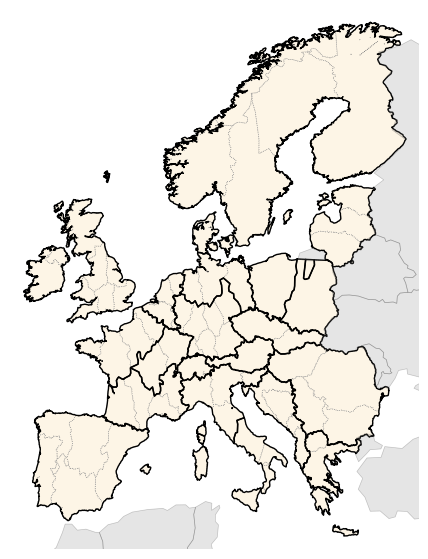

In [6]:
from shapely.ops import unary_union

fig, ax = plt.subplots(1, 1, figsize=(8, 7))

def plot_coarse_regions(ax):
    regions.plot(
        ax=ax,
        color="oldlace",
        edgecolor="grey",
        alpha=1,
        linewidth=0.5,
        label="name",
        linestyle=":"
        )

    for _, buses in coarse_regions.items():

        region = regions.loc[buses]
        poly = unary_union(region.geometry).buffer(0.01)
        gpd.GeoSeries([poly]).plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1.)

    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

plot_coarse_regions(ax)

plt.show()

In [20]:
years = list(range(1990, 2055, 5))

capex_template = str(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "breyer_sweep" /
    "egs_costs_s_72_{}.csv"
    )

year_costs = list()

for year in years:

    capex = pd.read_csv(capex_template.format(year)).set_index("name")["capex_min"]
    year_costs.append(capex)

year_costs = pd.concat(year_costs, axis=1).T
year_costs.index = years
year_costs = year_costs.T

year_costs

,1990,1995,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
name,,,,,,,,,,,,,
AL1 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AT1 0,8165.080729,5155.512777,3863.980514,2895.996200,2170.506285,1626.762333,1157.309927,818.765304,633.121868,458.300377,333.965435,263.265305,231.087259
BA1 0,28788.223092,20612.252713,15448.578304,11578.480767,8677.899950,6503.957561,4471.768002,3163.654265,2446.340470,1770.841945,1290.420059,1017.239498,892.905682
BE1 0,11757.384163,7847.891027,5881.878159,4408.380616,3304.016019,2476.311100,1734.648672,1227.216767,948.962747,686.929337,500.568330,394.598544,346.368071
BG1 0,18555.087740,12942.669238,9700.339015,7270.260507,5448.952635,4083.909344,2827.144816,2000.128081,1546.627369,1119.563140,815.830423,643.119986,564.513559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS1 0,15630.950334,10751.071535,8057.768977,6039.178577,4526.274951,3392.376077,2357.190690,1667.648316,1289.532681,933.459013,680.215554,536.214641,470.674901
SE2 0,23914.363066,16959.366766,12710.794357,9526.552225,7140.009880,5351.331718,3688.463284,2609.487476,2017.823152,1460.649455,1064.381472,839.053041,736.498366
SE2 1,28382.503047,20308.171544,15220.673969,11407.669842,8549.879689,6408.008271,4406.562513,3117.523154,2410.668936,1745.020254,1271.603682,1002.406528,879.885698


In [29]:

metrics = {
    "elec": "AC_geothermal_generation_share",
    "chp": "uch_geothermal_generation_share",
    "dh": "uch_geothermal_generation_share",
}

def get_data(app):

    header = [4,5,6,7,8]

    df = pd.read_csv(
        root / 
        "joint_data" /
        "nodal_geothermal_stats.csv", 
        index_col=[0,1], 
        header=header,
        ).sort_index()
    
    df = df.loc[:,idx[:,app]]

    this = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]

    totals = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]
    totals.index = totals.index.droplevel(1)

    this.columns = this.columns.get_level_values(0)
    this.index = this.index.get_level_values(0)

    # this = df.loc[idx[totals.index[:10], metrics[app]], idx[:,:,"static",:,:]]
    # this.columns = this.columns.get_level_values(0)
    # this.index = this.index.get_level_values(0)

    this.columns = this.columns.to_numpy().astype(int)
    this = this.loc[:,::-1]

    # print(this.head().T.head().T)

    x = np.linspace(year_costs.min().min(), year_costs.max().max(), 1000)

    data = pd.DataFrame(index=this.index.unique(), columns=[0.1, 0.2, 0.3])

    for bus, thresh in product(data.index[1:], data.columns):

        # xp = this.columns.to_numpy().astype(float)
        # print(xp)
        xp = year_costs.loc[bus, this.columns]
        yp = this.loc[bus].values.astype(float)

        # print(xp)
        # print(yp)
        
        # import sys
        # sys.exit()

        y = np.interp(x, xp, yp)
        data.loc[bus, thresh] = x[len(y[y > thresh])]
    
    data.columns = data.columns.to_numpy()
    return data

get_data("dh")

,0.1,0.2,0.3
location,,,
AL1 0,NaN,NaN,NaN
AT1 0,4865.63929,4615.822483,4324.369541
BA1 0,4241.097272,3991.280465,3741.463658
BE1 0,4241.097272,4032.9166,3824.735927
BG1 0,3991.280465,3824.735927,3699.827523
...,...,...,...
RS1 0,4366.005676,4199.461138,3991.280465
SE2 0,5198.728366,4990.547694,4824.003156
SE2 1,6156.35946,5906.542653,5615.089712


C:\Users\lukas\AppData\Local\Temp\ipykernel_30176\3320729904.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["250", "", "1500"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_30176\3320729904.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5500"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_30176\3320729904.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5350"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_30176\3320729904.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


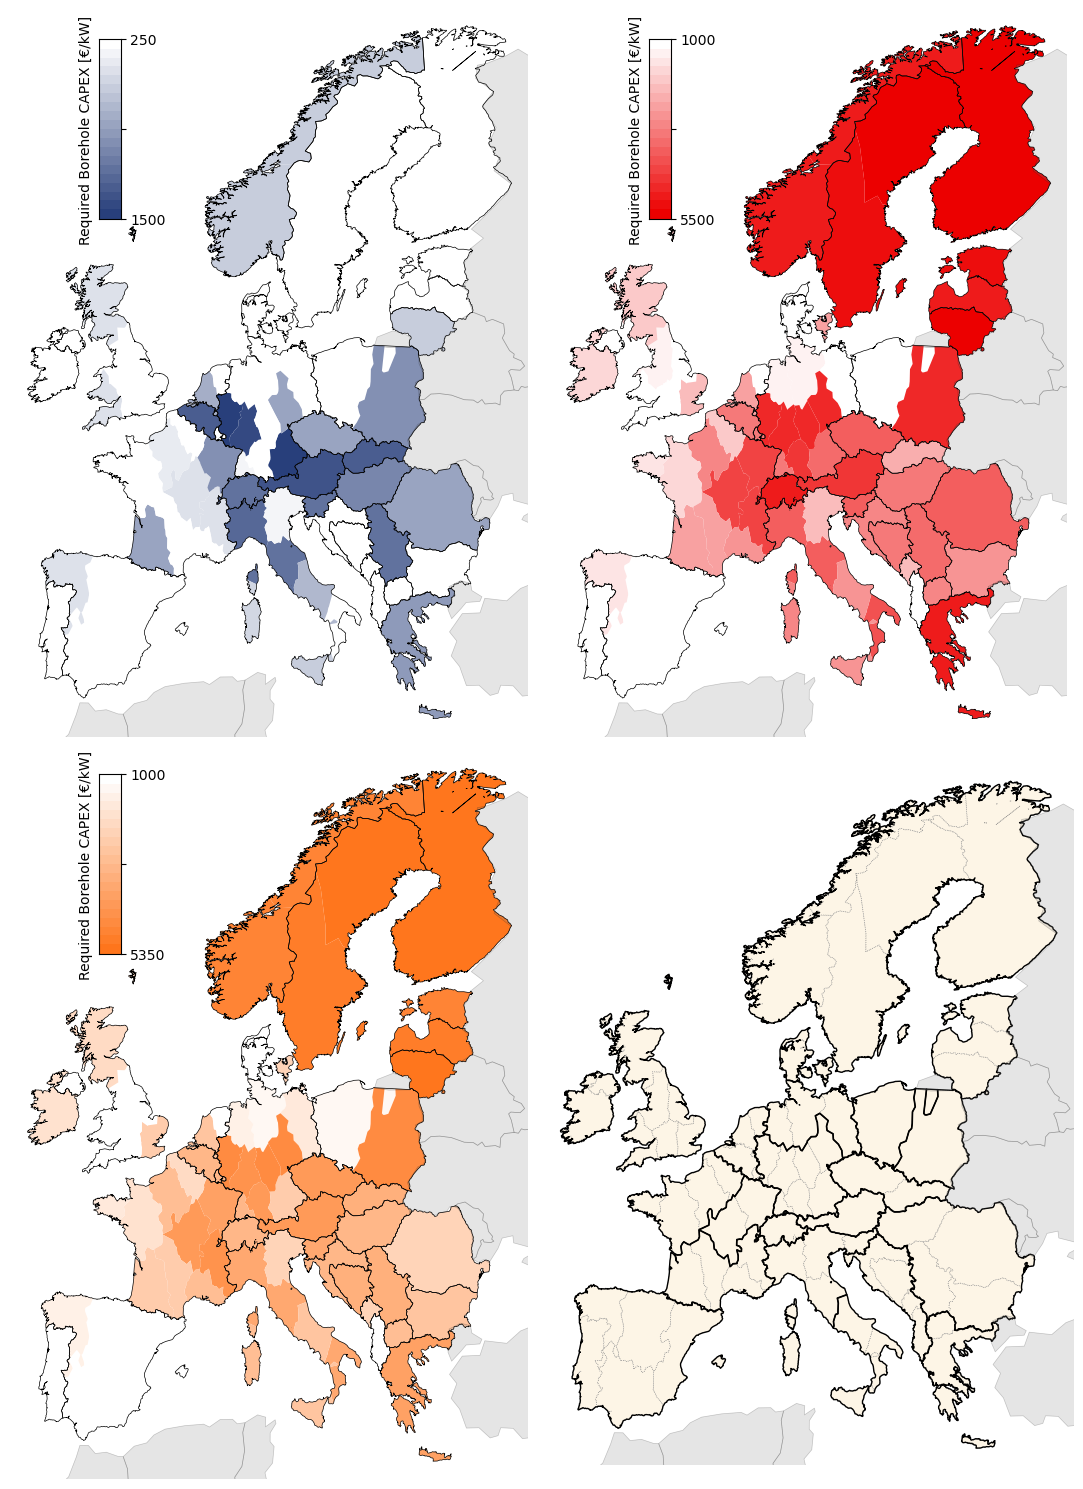

In [36]:

def plot_regions(col, ax):

    assert col in ["elec", "chp", "dh"]

    color = colors[col]
    regions[col] = get_data(col)[0.1]

    vmin = regions[col].min()
    vmax = regions[col].max()
    cmap = get_cm(color, **cmap_kwargs[col])

    regions.plot(
        ax=ax,
        column=col,
        label=f"10%",
        cmap=cmap,
        )
    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    countries.plot(
        ax=ax,
        color="none",
        edgecolor="black",
        linewidth=0.5,
        )

    cax_lims = {
        "chp": [0.10, 0.36, 0.02, 0.12],
        "dh": [0.60, 0.85, 0.02, 0.12],
        "elec": [0.10, 0.85, 0.02, 0.12],
    }

    cax = fig.add_axes(cax_lims.get(col, [0.35, 0.67, 0.02, 0.18]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cax.set_xticks([])

    y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
    y = np.hstack((y, y))

    cax.imshow(y, aspect='auto', cmap=cmap)# , vmin=vmin, vmax=vmax)
    cax.set_ylabel("Required Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))

    cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))
    if col == "elec":
        cax.set_yticklabels(["250", "", "1500"])
    elif col == "dh":
        cax.set_yticklabels(["1000", "", "5500"])
    elif col == "chp":
        cax.set_yticklabels(["1000", "", "5350"])
    else:
        print(cax.get_yticklabels())
        print(regions[col].min())
        print(regions[col].max())

    cax.yaxis.set_ticks_position("right")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)

fig, axs = plt.subplots(2, 2, figsize=(11., 15))
# ax.set_facecolor(adjust_lightness("brown", amount=1, asymetric=True))

plot_regions("elec", axs[0,0])
plot_regions("dh", axs[0,1])
plot_regions("chp", axs[1,0])
plot_coarse_regions(axs[-1,-1])


plt.tight_layout()
plt.savefig("geothermal_maps.pdf")
plt.show()

In [30]:
regions

,geometry,country,name,elec,dh,chp
name,,,,,,
AL1 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...",AL,AL1 0,NaN,NaN,NaN
AT1 0,"POLYGON ((13.86068 46.51525, 13.67026 46.51871...",AT,AT1 0,1493.112394,4865.63929,4740.730887
BA1 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...",BA,BA1 0,119.119954,4241.097272,4282.733407
BE1 0,"POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...",BE,BE1 0,1451.476259,4241.097272,4199.461138
BG1 0,"POLYGON ((23.94989 41.43758, 23.89480 41.46434...",BG,BG1 0,119.119954,3991.280465,3949.644331
...,...,...,...,...,...,...
RS1 0,"POLYGON ((20.75050 41.90680, 20.72331 41.86662...",RS,RS1 0,1284.931721,4366.005676,4366.005676
SE2 0,"MULTIPOLYGON (((12.97918 55.40327, 12.83277 55...",SE,SE2 0,119.119954,5198.728366,5198.728366
SE2 1,"MULTIPOLYGON (((17.49916 61.72383, 17.45725 61...",SE,SE2 1,119.119954,6156.35946,5948.178788


AttributeError: 'WindowsPath' object has no attribute 'format'

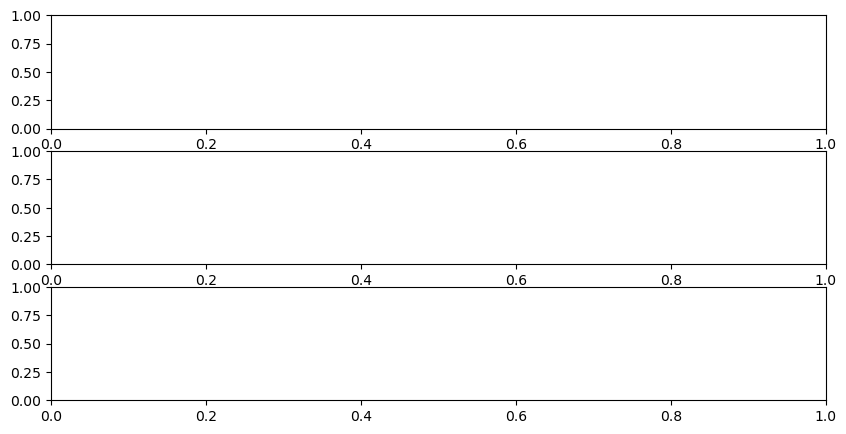

In [37]:
from matplotlib.ticker import LinearLocator
from matplotlib.pyplot import subplots_adjust
from scipy.interpolate import make_interp_spline, BSpline

fig, axs = plt.subplots(3, 1, figsize=(10, 5))

show_regions = {
    "elec": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Romania, Bulgaria, Serbia, Hungary",
        "Scandinavia (w/o DK)",
        ],
    "dh": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Scandinavia (w/o DK)",
        "Eastern Poland",
        "Western Poland",
        ],
    "chp": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Scandinavia (w/o DK)",
        "Eastern Poland",
        "Western Poland",
        ]
}

text_pos = {
    "elec": {
        "Iberia": (580,0.1),
        "Southern-Central Germany": (1600,0.06),
        "Austria": (1320,0.16),
        "Romania, Bulgaria, Serbia, Hungary": (1110,0.14),
        "Northern Germany": (1040,0.05),
        "Scandinavia (w/o DK)": (690,0.145),
    },
    "dh": {
        "Western Poland": (1700, 0.04),
        # "Northern Germany": (2000, 0.18),
        "Iberia": (3690, 0.1),
        "Scandinavia (w/o DK)": (5850,0.145),
        "Eastern Poland": (5140, 0.10),
        "Northern Germany": (2400,0.08),
        "Southern-Central Germany": (4190,0.1),
        "Austria": (4720,0.09),
    },
    "chp": {
        "Western Poland": (2000, 0.16),
        "Scandinavia (w/o DK)": (5590,0.145),
        "Eastern Poland": (4820, 0.02),
        "Southern-Central Germany": (4620,0.12),
        "Austria": (3840,0.17),
        "Iberia": (3170,0.17),
        "Northern Germany": (3000, 0.062),
    },
}

renames = {
    "elec": {
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Romania, Bulgaria, Serbia, Hungary": "Romania, Bulgaria,\nSerbia, Hungary",
        "Northern Germany": "Northern\nGermany",
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
    },
    "dh": {
        "Northern Germany": "Northern\nGermany",
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
        "Eastern Poland": "Eastern\nPoland",
    },
    "chp": {
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
        "Eastern Poland": "Eastern\nPoland",
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Northern Germany": "Northern\nGermany",
    },
}


apps = ["elec", "dh", "chp"]
for i, app in enumerate(apps):

    header = [4,5,6,7,8]

    df = pd.read_csv(
        Path(root.format(app)) /
        "nodal_geothermal_stats.csv", 
        index_col=[0,1], 
        header=header,
        ).sort_index()
    color = colors[app]

    totals = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]
    totals.index = totals.index.droplevel(1)

    metric = metrics[app].split("_")[0]

    cmap = get_cm(color, **cmap_kwargs[app])

    for region_name, buses in coarse_regions.items():

        if region_name not in show_regions[app]:
            continue

        total = df.loc[idx[buses, f"{metric}_total_generation"], idx[:,:,"static",:,:]]
        geogen = df.loc[idx[buses, f"{metric}_geothermal_generation"], idx[:,:,"static",:,:]]

        def reduce_ind(df):
            df.columns = df.columns.get_level_values(0)
            df.index = df.index.get_level_values(0)
            return df
        
        total = reduce_ind(total).sum()
        geogen = reduce_ind(geogen).sum()

        x = geogen.index.to_numpy().astype(float)
        y = (geogen / total).values

        thresh = 0.1

        new_x = np.linspace(x[0], x[-1], 200)
        new_y = np.interp(new_x, x, y)

        value = new_x[len(new_y[new_y > thresh])]
        text_value = new_x[len(new_y[new_y > 0.2])]

        series = pd.Series(new_y, index=new_x).rolling(5, center=True).mean()

        if not region_name in text_pos[app]:
            text_y = 0.2 - np.random.rand() * 0.1
        else:
            text_value = text_pos[app][region_name][0]
            text_y = text_pos[app][region_name][1]

        axs[i].plot(series.index, series.values, color=cmap(value/max(x)), linewidth=3, label=region_name)
        # axs[i].text(text_value, text_y, region_name, horizontalalignment="right", fontsize=10, weight='bold')
        axs[i].text(text_value, text_y, renames[app].get(region_name, region_name), horizontalalignment="right", fontsize=10, weight='bold')

        # print(value, region_name, app)

xlimits = {
    "elec": (390, 1610),
    "dh": (2000, 5600),
    "chp": (2000, 5600),
}


for ax in axs:
    ax.set_ylim(-0.0, 0.2)
    ax.grid(linestyle="--", color="grey", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.yaxis.set_major_locator(LinearLocator(numticks=3))
    ax.set_yticklabels(["0", "10", "20"])

axs[0].spines["top"].set_visible(True)

axs[0].set_ylabel("Electricity [%]")
axs[1].set_ylabel("EGS Generation Share\nCentral Heat [%]")
axs[2].set_ylabel("CHP [%]")

# axs[0].xaxis.set_label_position("top")
axs[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[1].set_xticklabels([])
axs[-1].set_xlabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))

plt.tight_layout()

subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=None
    )

plt.savefig("generation_shares.pdf")
plt.show()